In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from scipy.sparse import csr_matrix

In [2]:
df=pd.read_csv("/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**Check Data Structure**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [5]:
df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


**Exploratory Data Analysis (EDA)**

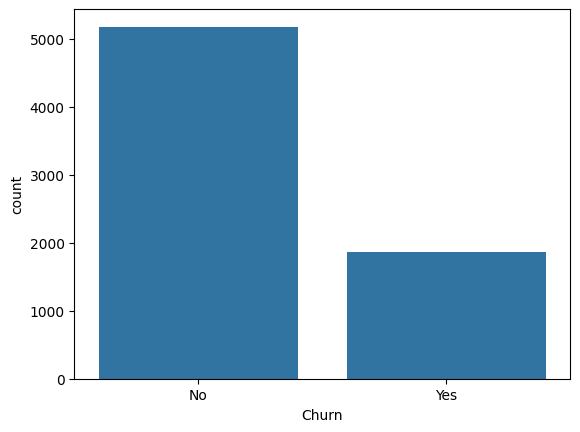

In [6]:
#How many customers churned
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Churn', data=df)
plt.show()

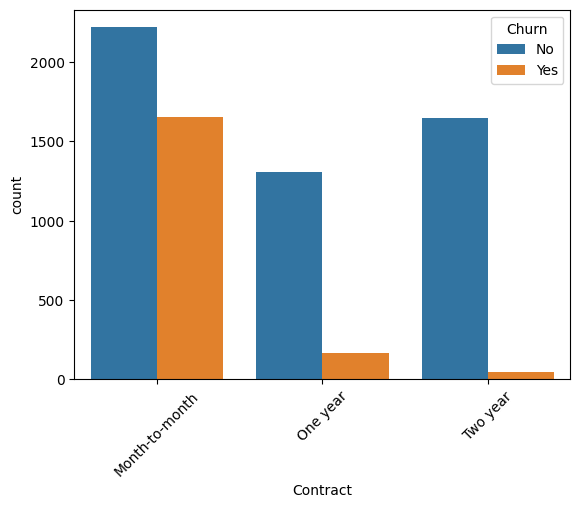

In [7]:
#Churn  based on contract type
sns.countplot(x='Contract', hue='Churn', data=df)
plt.xticks(rotation=45)
plt.show()

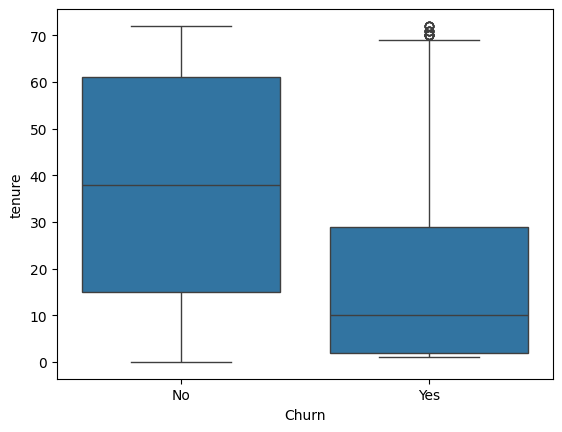

In [8]:
#Churn based on tenure
sns.boxplot(x='Churn', y='tenure', data=df)
plt.show()

**Data Cleaning**

In [9]:
#Identify and remove columns that are not useful for prediction
df.drop('customerID', axis=1, inplace=True)

In [10]:
#Convert 'TotalCharges' from object to numeric
df['TotalCharges'] = df['TotalCharges'].replace(' ', pd.NA)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.fillna({'TotalCharges':df['TotalCharges'].median()}, inplace=True)

In [11]:
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

**Train-Test Split**

In [12]:
X = df.drop(columns=['Churn'],axis=1)
y = df['Churn']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

**Create preprocessing pipeline**

In [14]:
#Define column types
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [15]:
#preprocessing for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols)
    ]
)

In [16]:
#Preprocess training data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)


**Train the Model**

In [17]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    max_iter=2000,
    class_weight='balanced',
    solver='saga',
    random_state=42
)


log_reg.fit(X_train_preprocessed, y_train)

LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42,
                   solver='saga')

In [18]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=400,
    class_weight='balanced',
    max_depth=None,
    random_state=42
)
rf.fit(X_train_preprocessed, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=400,
                       random_state=42)

In [19]:
#XG Boost
from xgboost import XGBClassifier

scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1])

xgb = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

xgb.fit(X_train_preprocessed, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

**Model Evaluation**

In [20]:
from sklearn.metrics import accuracy_score, classification_report

for model in [log_reg, rf, xgb]:
    pred = model.predict(X_test_preprocessed)
    print(type(model).__name__)
    print("Accuracy:", accuracy_score(y_test, pred))
    print(classification_report(y_test, pred))


LogisticRegression
Accuracy: 0.7381121362668559
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.50      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409

RandomForestClassifier
Accuracy: 0.7814052519517388
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1035
           1       0.62      0.47      0.53       374

    accuracy                           0.78      1409
   macro avg       0.72      0.68      0.69      1409
weighted avg       0.77      0.78      0.77      1409

XGBClassifier
Accuracy: 0.752306600425834
              precision    recall  f1-score   support

           0       0.87      0.78      0.82      1035
           1       0.53      0.67      0.59       374

    accuracy                           0

**Save the best model**

In [21]:
#XGBoost is giving the best balanced behavior
import joblib

joblib.dump(xgb, "churn_model.pkl")


['churn_model.pkl']